In [75]:
#Save the below parameters to output.txt file
%logstart -o -r -t -q output.txt rotate

In [76]:
def calc_dx_dt(f0, v):
    dx = v * 1/f0 / 10
    dy = dx
    dt = dx / v / 3
    return dx, dt

In [77]:
# General info
# using Adam Optimization
# Shuffling sources every epoch
# SCHUSTER's MARMOUSI MODEL

# General parameters
GPU=4     # which GPU to use
plot=False # Plot Intermediate results
sigma=10.0   # Initial model smoothness  

# Inversion parameters
num_batches = 2
num_epochs = 5000

#gamma = 300  # Does not apply, Adam uses lr (learning rate) instead of gamma
# Adam learning rate
lr = 4

# Modeling parameters
freq = 15
dx = 10
dt = 0.001
nt = 4001
num_shots = 20
num_receivers_per_shot = 250
plot = True

# receiver_spacing = # computed below from ny,dx and num_receivers_per_shot

# Close the ouput.txt file with saved parameters
%logstop 

In [78]:
# Need to restart runtime before this step
import time
import torch
import numpy as np
import scipy.ndimage
import scipy.io
import matplotlib.pyplot as plt
import deepwave
import os
import csv
from sklearn.feature_extraction import image
from skimage.transform import resize

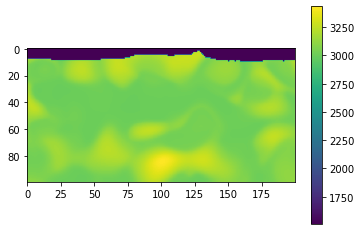

In [79]:
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi23/FakeAD0ep10.npy')
im1 = im1[0,0,:,25:225]*1000
plt.imshow(im1)
plt.colorbar()

In [80]:
bigm = np.zeros((100,250))
mat = im1
mat = resize(mat,(100,200),anti_aliasing=True)
bigm[:,25:225] = mat
bigm[:,0:25] = np.expand_dims(mat[:,0],axis=1)
bigm[:,225:250] = np.expand_dims(mat[:,199],axis=1)
mat = bigm
#mat = np.loadtxt('marmhard2.dat')
#mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
#RB Get model size
ny = np.size(mat,1);
nz = np.size(mat,0);
#RB compute true model mean value and width for future model normalization
max1=np.max(mat)
min1=np.min(mat)
med=(max1+min1)/2.
wid=(max1-min1)/2.
mat = bigm

In [81]:
wb = 0*mat
wb[(mat==1510)]=1

In [82]:
# Specify which GPU to use (in multi GPU machines)
torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
GPU_string='cuda:'+str(GPU)
device = torch.device(GPU_string)

In [83]:
# Set parameters
num_dims = 2
#num_shots = 32
num_sources_per_shot = 1
#num_receivers_per_shot = 200

#RB source_spacing = 25.0
#RB receiver_spacing = 10.0
source_spacing = ny * dx / num_shots
receiver_spacing = ny * dx / num_receivers_per_shot
#receiver_spacing = 8.

print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
      'ds=',source_spacing,'dr=',receiver_spacing)

ny= 250 nz= 100 nt= 4001 dx= 10 freq= 15
shots= 20 recs/shot= 250 ds= 125.0 dr= 10.0


In [84]:
nnz = np.zeros(250)
for i in range(250):
    nnz[i] = np.max(np.nonzero(wb[:,i]))

In [85]:
# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
#x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
x_s[:,0,1] = torch.linspace(0,(ny-1)*dx,num_shots)
#x_s[:, 0, 0] = 100. #RB Set source depth

x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
for i in range(250):
    x_r[0,i,0] = nnz[i]*dx  
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)
x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

#RB Shuffle shot coordinates
###idx = torch.randperm(num_shots)
###x_s = x_s.view(-1,2)[idx].view(x_s.size())

#RB Set Receiver depth
#x_r[0, :, 0] = 100.
#x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [86]:
#RB Generate a cte velocy model (with water velocity)
mat2 = np.ones((nz,ny),np.float32)*1510.

mat2[nz-1,int(ny/2)]=max1  # put a pixel with true upper velocity to fix a propagator problem

In [87]:
model_true = torch.Tensor(mat)
model_cte = torch.Tensor(mat2) # Convert to a PyTorch Tensor

In [88]:
###### Create 'true' data 
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()
prop2 = deepwave.scalar.Propagator({'vp': model_cte.to(device)}, dx)
receiver_amplitudes_cte = prop2(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()
seis = receiver_amplitudes_all - receiver_amplitudes_cte
seis10=np.squeeze(seis.cpu().detach().numpy())

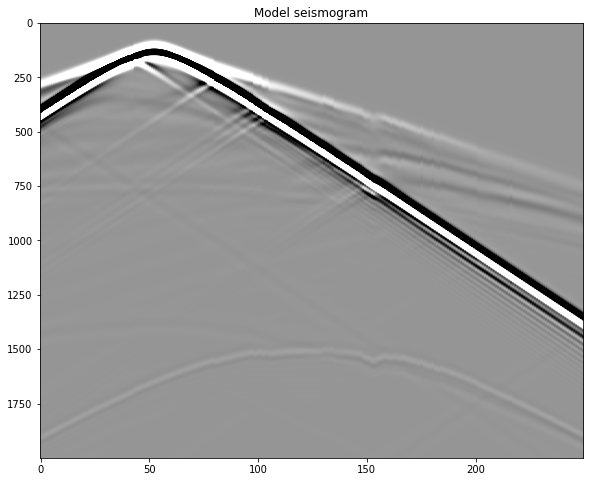

In [94]:
if plot==True:
    plt.figure(figsize=(12, 8))
    plt.imshow(seis10[0:2000,4], vmin=-0.25,vmax=0.25,aspect=0.1,cmap='Greys')
    
    plt.title('Model seismogram')

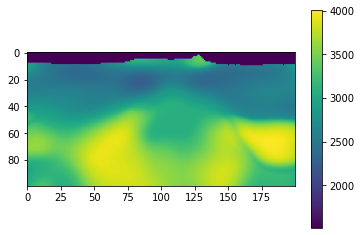

In [59]:
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi23/FakeAD0ep100.npy')
im1 = im1[0,0,:,25:225]*1000
plt.imshow(im1)
plt.colorbar()
bigm = np.zeros((100,250))
mat = im1
mat = resize(mat,(100,200),anti_aliasing=True)
bigm[:,25:225] = mat
bigm[:,0:25] = np.expand_dims(mat[:,0],axis=1)
bigm[:,225:250] = np.expand_dims(mat[:,199],axis=1)
mat = bigm
#mat = np.loadtxt('marmhard2.dat')
#mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
#RB Get model size
ny = np.size(mat,1);
nz = np.size(mat,0);
#RB compute true model mean value and width for future model normalization
max1=np.max(mat)
min1=np.min(mat)
med=(max1+min1)/2.
wid=(max1-min1)/2.
mat = bigm
model_true = torch.Tensor(mat)
model_cte = torch.Tensor(mat2) # Convert to a PyTorch Tensor
###### Create 'true' data 
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()
prop2 = deepwave.scalar.Propagator({'vp': model_cte.to(device)}, dx)
receiver_amplitudes_cte = prop2(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()
seis = receiver_amplitudes_all - receiver_amplitudes_cte
seis100=np.squeeze(seis.cpu().detach().numpy())

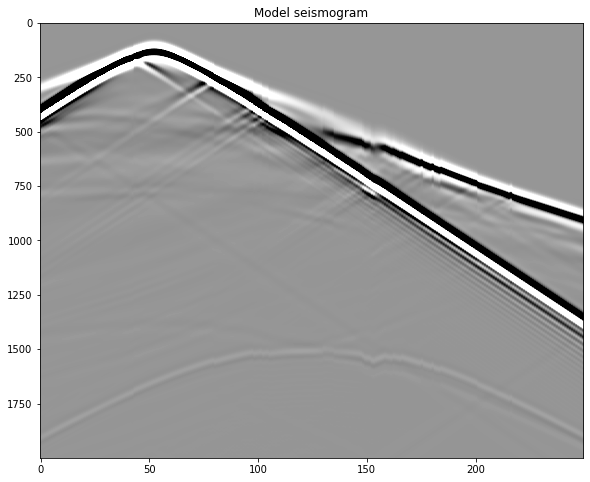

In [95]:
if plot==True:
    plt.figure(figsize=(12, 8))
    plt.imshow(seis100[0:2000,4], vmin=-0.25,vmax=0.25,aspect=0.1,cmap='Greys')
    
    plt.title('Model seismogram')

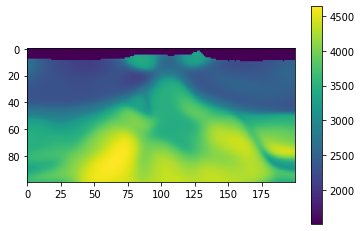

In [61]:
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi23/FakeAD0ep300.npy')
im1 = im1[0,0,:,25:225]*1000
plt.imshow(im1)
plt.colorbar()
bigm = np.zeros((100,250))
mat = im1
mat = resize(mat,(100,200),anti_aliasing=True)
bigm[:,25:225] = mat
bigm[:,0:25] = np.expand_dims(mat[:,0],axis=1)
bigm[:,225:250] = np.expand_dims(mat[:,199],axis=1)
mat = bigm
#mat = np.loadtxt('marmhard2.dat')
#mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
#RB Get model size
ny = np.size(mat,1);
nz = np.size(mat,0);
#RB compute true model mean value and width for future model normalization
max1=np.max(mat)
min1=np.min(mat)
med=(max1+min1)/2.
wid=(max1-min1)/2.
mat = bigm
model_true = torch.Tensor(mat)
model_cte = torch.Tensor(mat2) # Convert to a PyTorch Tensor
###### Create 'true' data 
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()
prop2 = deepwave.scalar.Propagator({'vp': model_cte.to(device)}, dx)
receiver_amplitudes_cte = prop2(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()
seis = receiver_amplitudes_all - receiver_amplitudes_cte
seis300=np.squeeze(seis.cpu().detach().numpy())

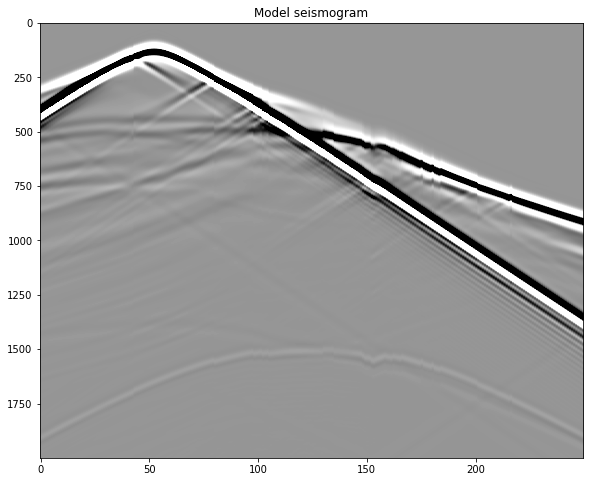

In [96]:
if plot==True:
    plt.figure(figsize=(12, 8))
    plt.imshow(seis300[0:2000,4], vmin=-0.25,vmax=0.25,aspect=0.1,cmap='Greys')
    
    plt.title('Model seismogram')

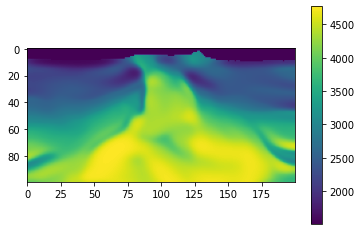

In [63]:
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi23/FakeAD0ep600.npy')
im1 = im1[0,0,:,25:225]*1000
plt.imshow(im1)
plt.colorbar()
bigm = np.zeros((100,250))
mat = im1
mat = resize(mat,(100,200),anti_aliasing=True)
bigm[:,25:225] = mat
bigm[:,0:25] = np.expand_dims(mat[:,0],axis=1)
bigm[:,225:250] = np.expand_dims(mat[:,199],axis=1)
mat = bigm
#mat = np.loadtxt('marmhard2.dat')
#mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
#RB Get model size
ny = np.size(mat,1);
nz = np.size(mat,0);
#RB compute true model mean value and width for future model normalization
max1=np.max(mat)
min1=np.min(mat)
med=(max1+min1)/2.
wid=(max1-min1)/2.
mat = bigm
model_true = torch.Tensor(mat)
model_cte = torch.Tensor(mat2) # Convert to a PyTorch Tensor
###### Create 'true' data 
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()
prop2 = deepwave.scalar.Propagator({'vp': model_cte.to(device)}, dx)
receiver_amplitudes_cte = prop2(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()
seis = receiver_amplitudes_all - receiver_amplitudes_cte
seis600=np.squeeze(seis.cpu().detach().numpy())

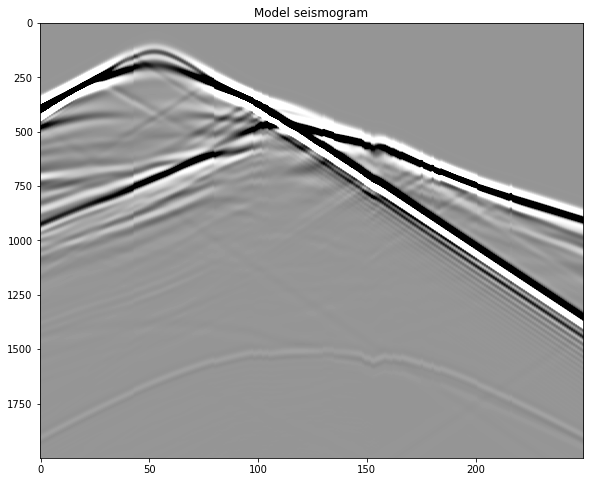

In [97]:
if plot==True:
    plt.figure(figsize=(12, 8))
    plt.imshow(seis600[0:2000,4], vmin=-0.25,vmax=0.25,aspect=0.1,cmap='Greys')
    
    plt.title('Model seismogram')

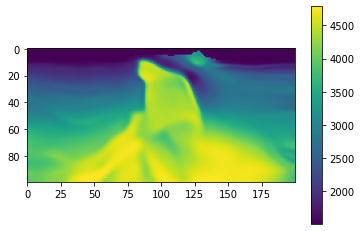

In [65]:
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi23/FakeAD0ep1200.npy')
im1 = im1[0,0,:,25:225]*1000
plt.imshow(im1)
plt.colorbar()
bigm = np.zeros((100,250))
mat = im1
mat = resize(mat,(100,200),anti_aliasing=True)
bigm[:,25:225] = mat
bigm[:,0:25] = np.expand_dims(mat[:,0],axis=1)
bigm[:,225:250] = np.expand_dims(mat[:,199],axis=1)
mat = bigm
#mat = np.loadtxt('marmhard2.dat')
#mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
#RB Get model size
ny = np.size(mat,1);
nz = np.size(mat,0);
#RB compute true model mean value and width for future model normalization
max1=np.max(mat)
min1=np.min(mat)
med=(max1+min1)/2.
wid=(max1-min1)/2.
mat = bigm
model_true = torch.Tensor(mat)
model_cte = torch.Tensor(mat2) # Convert to a PyTorch Tensor
###### Create 'true' data 
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()
prop2 = deepwave.scalar.Propagator({'vp': model_cte.to(device)}, dx)
receiver_amplitudes_cte = prop2(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()
seis = receiver_amplitudes_all - receiver_amplitudes_cte
seis1200=np.squeeze(seis.cpu().detach().numpy())

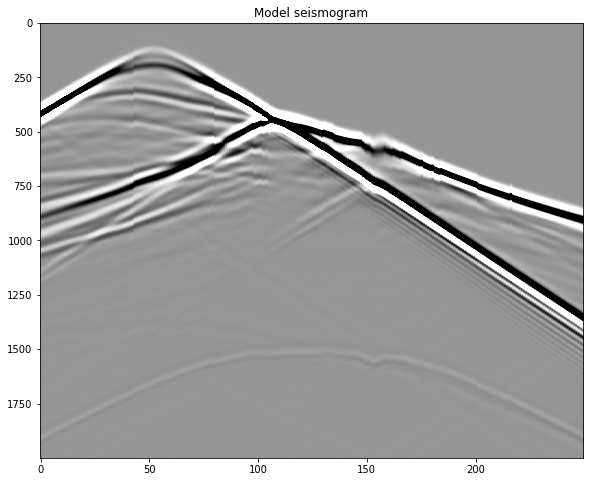

In [98]:
if plot==True:
    plt.figure(figsize=(12, 8))
    plt.imshow(seis1200[0:2000,4], vmin=-0.25,vmax=0.25,aspect=0.1,cmap='Greys')
    
    plt.title('Model seismogram')

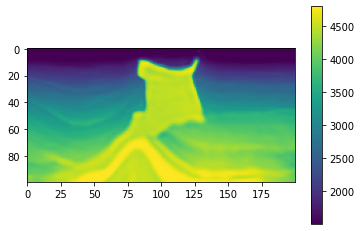

In [69]:
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi23/FakeAD0ep3000.npy')
im1 = im1[0,0,:,25:225]*1000
plt.imshow(im1)
plt.colorbar()
bigm = np.zeros((100,250))
mat = im1
mat = resize(mat,(100,200),anti_aliasing=True)
bigm[:,25:225] = mat
bigm[:,0:25] = np.expand_dims(mat[:,0],axis=1)
bigm[:,225:250] = np.expand_dims(mat[:,199],axis=1)
mat = bigm
#mat = np.loadtxt('marmhard2.dat')
#mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
#RB Get model size
ny = np.size(mat,1);
nz = np.size(mat,0);
#RB compute true model mean value and width for future model normalization
max1=np.max(mat)
min1=np.min(mat)
med=(max1+min1)/2.
wid=(max1-min1)/2.
mat = bigm
model_true = torch.Tensor(mat)
model_cte = torch.Tensor(mat2) # Convert to a PyTorch Tensor
###### Create 'true' data 
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()
prop2 = deepwave.scalar.Propagator({'vp': model_cte.to(device)}, dx)
receiver_amplitudes_cte = prop2(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()
seis = receiver_amplitudes_all - receiver_amplitudes_cte
seis3000=np.squeeze(seis.cpu().detach().numpy())

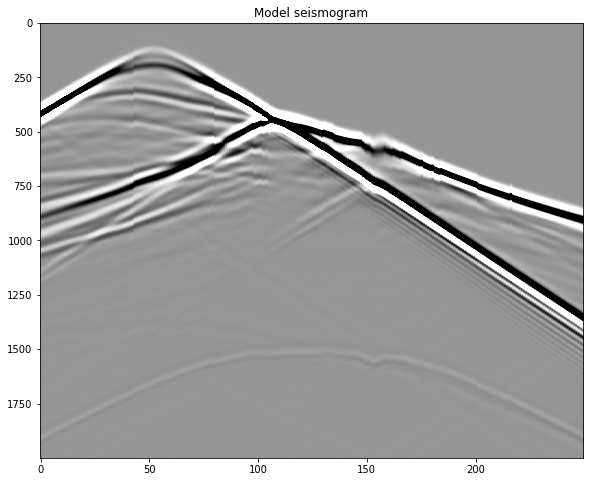

In [99]:
if plot==True:
    plt.figure(figsize=(12, 8))
    plt.imshow(seis3000[0:2000,4], vmin=-0.25,vmax=0.25,aspect=0.1,cmap='Greys')
    
    plt.title('Model seismogram')

Text(0.5, 1.0, 'iteration 3000')

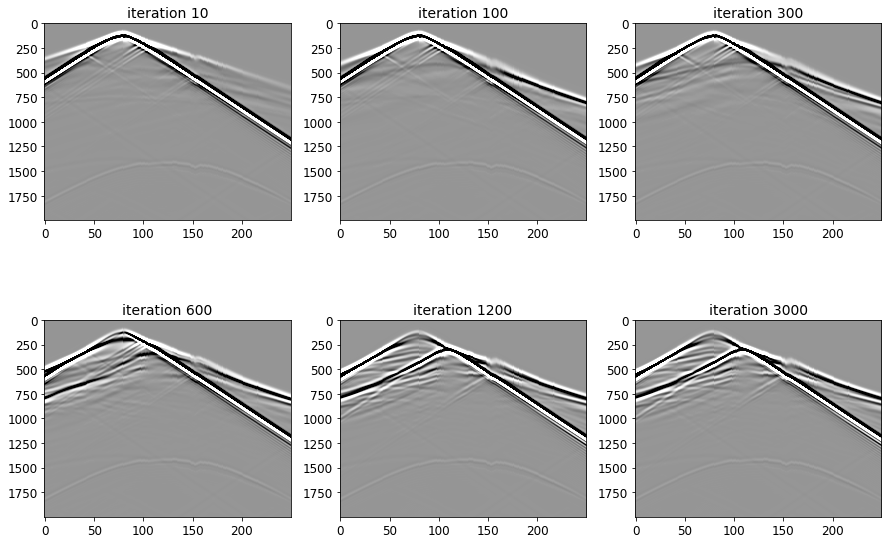

In [120]:
rows = 2
columns = 3
fig1 = plt.figure(figsize=(15,10))


ax = fig1.add_subplot(rows,columns,1)
im = plt.imshow(seis10[0:2000,6], vmin=-0.25, vmax=0.25, cmap='Greys', aspect=0.1)
ax = plt.gca(); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title("iteration 10",fontsize=14)

ax = fig1.add_subplot(rows,columns,2)
im = plt.imshow(seis100[0:2000,6], vmin=-0.25, vmax=0.25, cmap='Greys', aspect=0.1)
ax = plt.gca(); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title("iteration 100",fontsize=14)

ax = fig1.add_subplot(rows,columns,3)
im = plt.imshow(seis300[0:2000,6], vmin=-0.25, vmax=0.25, cmap='Greys', aspect=0.1)
ax = plt.gca(); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title("iteration 300",fontsize=14)

ax = fig1.add_subplot(rows,columns,4)
im = plt.imshow(seis600[0:2000,6], vmin=-0.25, vmax=0.25, cmap='Greys', aspect=0.1)
ax = plt.gca(); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title("iteration 600",fontsize=14)

ax = fig1.add_subplot(rows,columns,5)
im = plt.imshow(seis1200[0:2000,6], vmin=-0.25, vmax=0.25, cmap='Greys', aspect=0.1)
ax = plt.gca(); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title("iteration 1200",fontsize=14)

ax = fig1.add_subplot(rows,columns,6)
im = plt.imshow(seis3000[0:2000,6], vmin=-0.25, vmax=0.25, cmap='Greys', aspect=0.1)
ax = plt.gca(); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title("iteration 3000",fontsize=14)